# Chronos - Basic Usage

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
my_ts_data.shape

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [ ]:
from chronos import Chronos

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=1000, learning_rate=0.1)
my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=365)
future_df

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)

In [ ]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016.\nMAE={MAE}", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [ ]:
my_chronos.plot_components(predictions)

## AAPL stocks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [2]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561


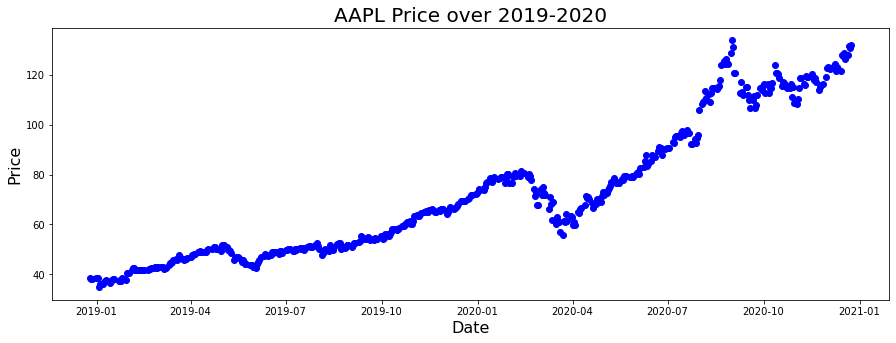

In [3]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [15]:
my_chronos = Chronos(method="MLE", max_iter=10000, 
                     learning_rate=0.1, 
                     n_changepoints=10,
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation
100.0% - ELBO loss: 2.75                                                                            


In [16]:
future_df = my_chronos.make_future_dataframe(period=31)
future_df

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561
...,...,...
531,2021-01-20,NaN
532,2021-01-21,NaN
533,2021-01-22,NaN
534,2021-01-23,NaN


In [17]:
predictions = my_chronos.predict(future_df, sample_number=1000)

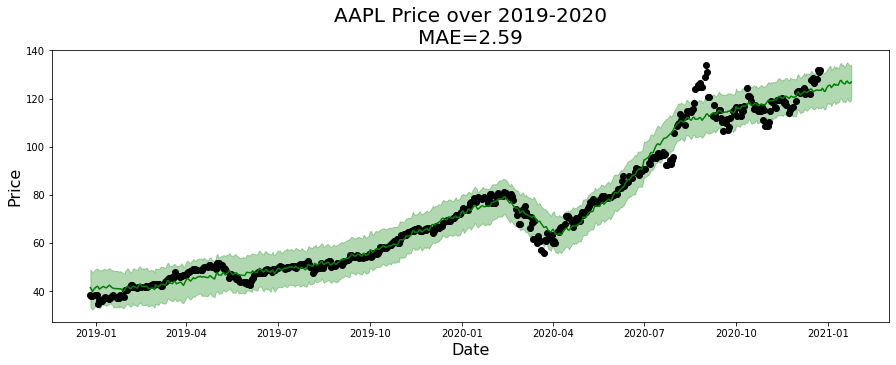

In [18]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020\nMAE={MAE}", size=20)
plt.show()

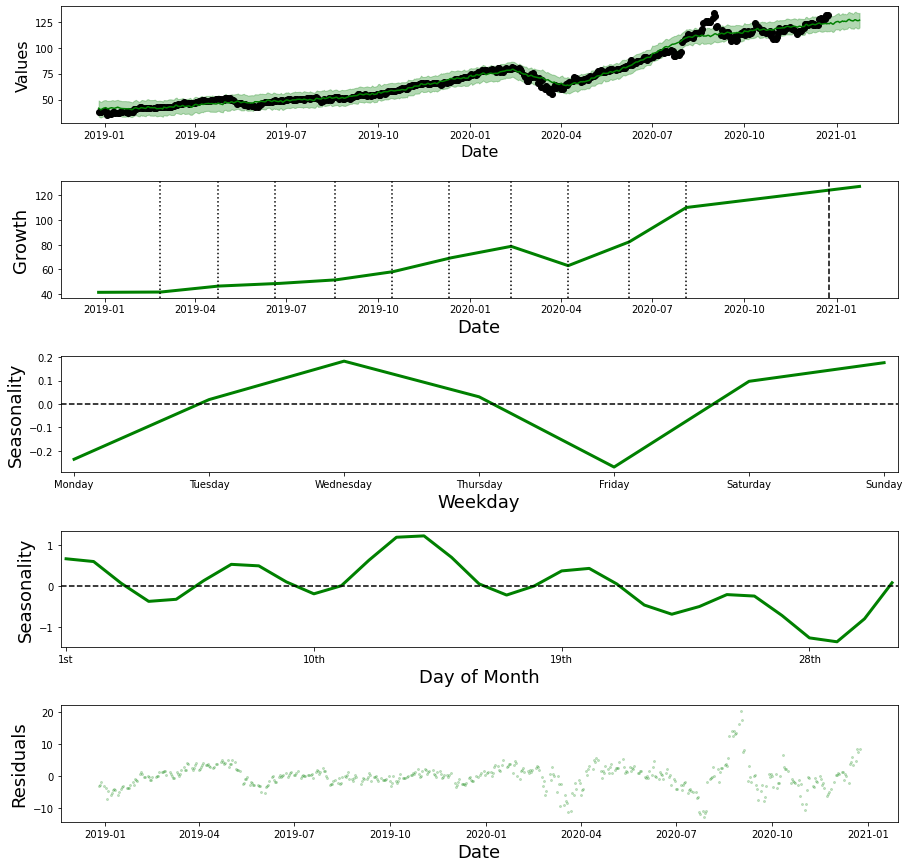

In [19]:
my_chronos.plot_components(predictions)